In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris["data"][:, 2:]
y = iris["target"]

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

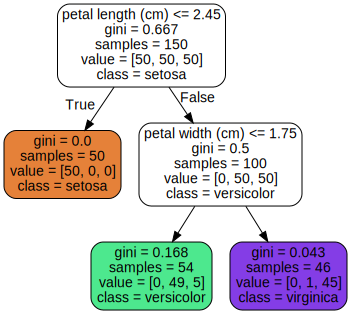

In [ ]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

In [ ]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [ ]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

array([[-0.56413534,  0.29283681],
       [-1.16033479,  0.96512577],
       [-0.06598769, -0.15191052],
       ...,
       [ 0.38876425, -0.78662881],
       [ 2.50492832,  0.21133631],
       [ 0.35428745,  0.74582457]])

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [ ]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [ ]:
grid_search_cv.best_score_

0.8555001986342105

In [ ]:
tree_reg = DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
tree_reg.fit(X_train, y_train)
y_predict = tree_reg.predict(X_test)
accuracy_score(y_test, y_predict)

0.8695

In [ ]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
  X_mini_train = X_train[mini_train_index]
  y_mini_train = y_train[mini_train_index]
  mini_sets.append((X_mini_train, y_mini_train))

In [ ]:
from sklearn.base import clone 

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
  tree.fit(X_mini_train, y_mini_train)

  y_pred = tree.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805471

In [ ]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
  Y_pred[tree_index] = tree.predict(X_test)

In [ ]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
y_pred_majority_votes

<ipython-input-37-8a6b4e1e642d>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


array([[1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872